In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import f1_score

EMD_DIM = 768


class MyDataset(Dataset):
    """params: name, embed_file_path, name in ['train', 'test']"""
    def __init__(self, name, embed_path='../data/wordem.json', mode='int'):
        super(Dataset, self).__init__()
        with open('./data/' + name + 'p.json', 'r') as f:
            emb = json.load(f)
        # with open('./data/' + name + '.label', 'r') as f:
            # label = json.load(f)
        with open('../data/{}_text_label.json'.format(name), 'r') as f:
            text_label = json.load(f)
        _, label = text_label[0], text_label[1]
        self.feat = torch.Tensor([np.array(l) for l in emb])
        if mode == 'int':
            self.label = [np.array(l[1:]) for l in label]
        elif mode == 'prob' or mode == 'float':
            self.label = list()
            for l in label:
                tot_vote = l[0]
                prob = np.array([vote / tot_vote for vote in l[1:]])
                self.label.append(prob)
            self.label = torch.Tensor(self.label)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):
        return self.feat[item], self.label[item]



In [2]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
            Use nn.Sequential, to make the structure clear
        """
        super(TwoLayerNet, self).__init__()
        self.twolayernet = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        # x = np.mat(x)
        # x = x.view(-1, 300)
        """
            The backward gradient calculation will be automatically defined when we have defined the forward
        """
        x = x.view(-1, 768)
        y_pred = self.twolayernet(x)
        return y_pred


In [3]:
BATCH_SIZE = 64
lr = 0.005
EPOCHS = 20
EMBED_FILE_PATH = '../data/wordem.json'


# train part
trainset = MyDataset(name='train', embed_path=EMBED_FILE_PATH, mode='float')
testset = MyDataset(name='test', embed_path=EMBED_FILE_PATH, mode='float')
print(len(trainset))
print(len(testset))

In [35]:
def score_cor_ma_mi_wei(net2):
    net2.eval()
    cnt = 0
    # for feat, label in testset:
    pred_emotions = list()
    true_emotions = list()
    for feat, label in testset:
        if torch.argmax(net2(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            cnt += 1
        pred_emotions.append(int(torch.argmax(net2(torch.Tensor(feat))).item()))
        true_emotions.append(int(torch.argmax(torch.Tensor(label)).item()))
    # print('correct:', cnt)
    # print('ratio:', cnt / test_size)

    # 返回值的第一项是皮尔森相关系数，第二项是p_value值
    # 一般来说皮尔森相关系数越大，p_value越小，线性相关性就越大
    pears = list()
    for feat, label in testset:
        pred = torch.Tensor(net2(feat)[0]).detach().numpy()
        pears.append(pearsonr(label, pred))
    # print('corr:', np.mean(corr))
    # print('f_score_macro:', f1_score(true_emotions, pred_emotions, average='macro'))
    # print('f_score_micro:', f1_score(true_emotions, pred_emotions, average='micro'))
    # print('f_score_weighted:', f1_score(true_emotions, pred_emotions, average='weighted'))
    return [np.mean(pears), f1_score(true_emotions, pred_emotions, average='macro'), 
           f1_score(true_emotions, pred_emotions, average='micro'), f1_score(true_emotions, pred_emotions, average='weighted')]

In [38]:
# bert slower
train_loss_list = list()
train_ratio_list = list()
test_loss_list = list()
test_ratio_list = list()
corr_list = list()
macro_list = list()
micro_list = list()
weighted_list = list()

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False)

train_size = 2342
test_size = 2228
input_size, hidden_size, output_size = 768, 256, 8
model = TwoLayerNet(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

EPOCH = 1000
for epoch in range(EPOCH):
    model.train()
    train_loss = 0.0
    traincnt = 0
    for feat, label in trainloader:
        optimizer.zero_grad()
        pred = model(feat)
        loss = loss_fn(pred, label)
        # print(pred.shape, label.shape)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch %d,\t train_loss %f' % (epoch, train_loss / train_size), end='\t')
    train_loss_list.append(train_loss / train_size)
    
    
    model.eval()
    train_correc = 0
    for feat, label in trainset:
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            train_correc += 1
    print('train_ratio %f' % (train_correc / train_size), end='\t')
    train_ratio_list.append(train_correc / train_size)
    
    evalcnt = 0
    eval_loss = 0.0
    for feat, label in testset:
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            evalcnt += 1
        pred = model(feat)
        loss = loss_fn(pred[0], label)
        # print(pred[0].shape, label.shape)
        eval_loss += loss.item()
    print('eval_loss: %f' % (eval_loss / test_size), end='\t')
    print('eval_ratio:', evalcnt / test_size)
    test_loss_list.append(eval_loss / test_size)
    test_ratio_list.append(evalcnt / test_size)
    four_score = score_cor_ma_mi_wei(model)
    corr_list.append(four_score[0])
    macro_list.append(four_score[1])
    micro_list.append(four_score[2])
    weighted_list.append(four_score[3])

torch.save(model.state_dict(), 'new_bert_para{}.dict'.format(EPOCH))

Epoch 0,	 train_loss 0.001197	train_ratio 0.401366	eval_loss: 0.039684	eval_ratio: 0.46409335727109513
Epoch 1,	 train_loss 0.000641	train_ratio 0.401366	eval_loss: 0.038235	eval_ratio: 0.46409335727109513
Epoch 2,	 train_loss 0.000620	train_ratio 0.401366	eval_loss: 0.037328	eval_ratio: 0.46409335727109513
Epoch 3,	 train_loss 0.000589	train_ratio 0.451751	eval_loss: 0.035541	eval_ratio: 0.5044883303411131
Epoch 4,	 train_loss 0.000577	train_ratio 0.478651	eval_loss: 0.035121	eval_ratio: 0.5278276481149012
Epoch 5,	 train_loss 0.000563	train_ratio 0.497438	eval_loss: 0.034538	eval_ratio: 0.5399461400359067
Epoch 6,	 train_loss 0.000557	train_ratio 0.495303	eval_loss: 0.034297	eval_ratio: 0.5350089766606823
Epoch 7,	 train_loss 0.000551	train_ratio 0.489752	eval_loss: 0.035127	eval_ratio: 0.5327648114901257
Epoch 8,	 train_loss 0.000548	train_ratio 0.507259	eval_loss: 0.033757	eval_ratio: 0.5453321364452424
Epoch 9,	 train_loss 0.000535	train_ratio 0.503843	eval_loss: 0.033784	eval_rat

Epoch 80,	 train_loss 0.000471	train_ratio 0.537148	eval_loss: 0.032489	eval_ratio: 0.5430879712746858
Epoch 81,	 train_loss 0.000460	train_ratio 0.550811	eval_loss: 0.031263	eval_ratio: 0.5574506283662477
Epoch 82,	 train_loss 0.000457	train_ratio 0.546114	eval_loss: 0.031815	eval_ratio: 0.5547576301615799
Epoch 83,	 train_loss 0.000467	train_ratio 0.547822	eval_loss: 0.031510	eval_ratio: 0.5565529622980251
Epoch 84,	 train_loss 0.000461	train_ratio 0.551238	eval_loss: 0.032845	eval_ratio: 0.5439856373429084
Epoch 85,	 train_loss 0.000468	train_ratio 0.536721	eval_loss: 0.032284	eval_ratio: 0.5457809694793537
Epoch 86,	 train_loss 0.000465	train_ratio 0.545260	eval_loss: 0.031293	eval_ratio: 0.5578994614003591
Epoch 87,	 train_loss 0.000456	train_ratio 0.549957	eval_loss: 0.031909	eval_ratio: 0.550718132854578
Epoch 88,	 train_loss 0.000454	train_ratio 0.558070	eval_loss: 0.031333	eval_ratio: 0.559245960502693
Epoch 89,	 train_loss 0.000452	train_ratio 0.531170	eval_loss: 0.033267	eva

Epoch 173,	 train_loss 0.000431	train_ratio 0.530743	eval_loss: 0.034891	eval_ratio: 0.5426391382405745
Epoch 174,	 train_loss 0.000452	train_ratio 0.565329	eval_loss: 0.031561	eval_ratio: 0.5650807899461401
Epoch 175,	 train_loss 0.000438	train_ratio 0.571307	eval_loss: 0.031430	eval_ratio: 0.5538599640933572
Epoch 176,	 train_loss 0.000431	train_ratio 0.568745	eval_loss: 0.031259	eval_ratio: 0.5610412926391383
Epoch 177,	 train_loss 0.000429	train_ratio 0.567891	eval_loss: 0.031454	eval_ratio: 0.5650807899461401
Epoch 178,	 train_loss 0.000427	train_ratio 0.559778	eval_loss: 0.032115	eval_ratio: 0.5471274685816876
Epoch 179,	 train_loss 0.000450	train_ratio 0.570026	eval_loss: 0.031922	eval_ratio: 0.5466786355475763
Epoch 180,	 train_loss 0.000429	train_ratio 0.565329	eval_loss: 0.031990	eval_ratio: 0.5502692998204668
Epoch 181,	 train_loss 0.000432	train_ratio 0.569599	eval_loss: 0.031716	eval_ratio: 0.5623877917414721
Epoch 182,	 train_loss 0.000433	train_ratio 0.514091	eval_loss: 

Epoch 252,	 train_loss 0.000417	train_ratio 0.550384	eval_loss: 0.034012	eval_ratio: 0.5529622980251346
Epoch 253,	 train_loss 0.000430	train_ratio 0.547395	eval_loss: 0.032940	eval_ratio: 0.5394973070017953
Epoch 254,	 train_loss 0.000437	train_ratio 0.558924	eval_loss: 0.033239	eval_ratio: 0.559245960502693
Epoch 255,	 train_loss 0.000434	train_ratio 0.545687	eval_loss: 0.033765	eval_ratio: 0.5480251346499102
Epoch 256,	 train_loss 0.000439	train_ratio 0.552519	eval_loss: 0.032649	eval_ratio: 0.550718132854578
Epoch 257,	 train_loss 0.000429	train_ratio 0.567464	eval_loss: 0.032125	eval_ratio: 0.5623877917414721
Epoch 258,	 train_loss 0.000422	train_ratio 0.573015	eval_loss: 0.031896	eval_ratio: 0.5502692998204668
Epoch 259,	 train_loss 0.000419	train_ratio 0.579419	eval_loss: 0.031646	eval_ratio: 0.5614901256732495
Epoch 260,	 train_loss 0.000414	train_ratio 0.576857	eval_loss: 0.031745	eval_ratio: 0.5552064631956912
Epoch 261,	 train_loss 0.000426	train_ratio 0.555508	eval_loss: 0.

Epoch 331,	 train_loss 0.000415	train_ratio 0.576430	eval_loss: 0.032787	eval_ratio: 0.5327648114901257
Epoch 332,	 train_loss 0.000411	train_ratio 0.574295	eval_loss: 0.032927	eval_ratio: 0.5623877917414721
Epoch 333,	 train_loss 0.000412	train_ratio 0.583689	eval_loss: 0.032332	eval_ratio: 0.5421903052064632
Epoch 334,	 train_loss 0.000413	train_ratio 0.579419	eval_loss: 0.032360	eval_ratio: 0.5480251346499102
Epoch 335,	 train_loss 0.000427	train_ratio 0.573442	eval_loss: 0.032064	eval_ratio: 0.5525134649910234
Epoch 336,	 train_loss 0.000408	train_ratio 0.576430	eval_loss: 0.032055	eval_ratio: 0.5565529622980251
Epoch 337,	 train_loss 0.000417	train_ratio 0.577711	eval_loss: 0.032664	eval_ratio: 0.5578994614003591
Epoch 338,	 train_loss 0.000422	train_ratio 0.571307	eval_loss: 0.032451	eval_ratio: 0.550718132854578
Epoch 339,	 train_loss 0.000415	train_ratio 0.585824	eval_loss: 0.032170	eval_ratio: 0.5484739676840216
Epoch 340,	 train_loss 0.000412	train_ratio 0.576857	eval_loss: 0

Epoch 410,	 train_loss 0.000422	train_ratio 0.576430	eval_loss: 0.032291	eval_ratio: 0.5565529622980251
Epoch 411,	 train_loss 0.000410	train_ratio 0.567891	eval_loss: 0.032681	eval_ratio: 0.550718132854578
Epoch 412,	 train_loss 0.000413	train_ratio 0.559778	eval_loss: 0.033247	eval_ratio: 0.5516157989228008
Epoch 413,	 train_loss 0.000415	train_ratio 0.576003	eval_loss: 0.032318	eval_ratio: 0.5596947935368043
Epoch 414,	 train_loss 0.000418	train_ratio 0.565329	eval_loss: 0.033105	eval_ratio: 0.5565529622980251
Epoch 415,	 train_loss 0.000436	train_ratio 0.574295	eval_loss: 0.033463	eval_ratio: 0.5197486535008977
Epoch 416,	 train_loss 0.000415	train_ratio 0.579419	eval_loss: 0.032134	eval_ratio: 0.547576301615799
Epoch 417,	 train_loss 0.000403	train_ratio 0.572161	eval_loss: 0.032765	eval_ratio: 0.5556552962298025
Epoch 418,	 train_loss 0.000416	train_ratio 0.567037	eval_loss: 0.033784	eval_ratio: 0.5421903052064632
Epoch 419,	 train_loss 0.000415	train_ratio 0.570026	eval_loss: 0.

Epoch 489,	 train_loss 0.000400	train_ratio 0.586678	eval_loss: 0.032428	eval_ratio: 0.546229802513465
Epoch 490,	 train_loss 0.000403	train_ratio 0.584543	eval_loss: 0.032671	eval_ratio: 0.5403949730700179
Epoch 491,	 train_loss 0.000413	train_ratio 0.584543	eval_loss: 0.032308	eval_ratio: 0.546229802513465
Epoch 492,	 train_loss 0.000403	train_ratio 0.576003	eval_loss: 0.033104	eval_ratio: 0.526032315978456
Epoch 493,	 train_loss 0.000410	train_ratio 0.584970	eval_loss: 0.032479	eval_ratio: 0.5421903052064632
Epoch 494,	 train_loss 0.000401	train_ratio 0.576003	eval_loss: 0.033139	eval_ratio: 0.5605924596050269
Epoch 495,	 train_loss 0.000411	train_ratio 0.583689	eval_loss: 0.032909	eval_ratio: 0.5502692998204668
Epoch 496,	 train_loss 0.000403	train_ratio 0.586678	eval_loss: 0.033071	eval_ratio: 0.5291741472172352
Epoch 497,	 train_loss 0.000403	train_ratio 0.576003	eval_loss: 0.033172	eval_ratio: 0.5596947935368043
Epoch 498,	 train_loss 0.000402	train_ratio 0.553373	eval_loss: 0.0

Epoch 568,	 train_loss 0.000401	train_ratio 0.582835	eval_loss: 0.033376	eval_ratio: 0.524685816876122
Epoch 569,	 train_loss 0.000410	train_ratio 0.584970	eval_loss: 0.033832	eval_ratio: 0.518850987432675
Epoch 570,	 train_loss 0.000414	train_ratio 0.562767	eval_loss: 0.035309	eval_ratio: 0.48967684021543983
Epoch 571,	 train_loss 0.000406	train_ratio 0.587105	eval_loss: 0.032336	eval_ratio: 0.5498204667863554
Epoch 572,	 train_loss 0.000398	train_ratio 0.567464	eval_loss: 0.034538	eval_ratio: 0.5574506283662477
Epoch 573,	 train_loss 0.000399	train_ratio 0.585824	eval_loss: 0.032937	eval_ratio: 0.5377019748653501
Epoch 574,	 train_loss 0.000421	train_ratio 0.587532	eval_loss: 0.032598	eval_ratio: 0.5412926391382405
Epoch 575,	 train_loss 0.000409	train_ratio 0.578992	eval_loss: 0.033878	eval_ratio: 0.5228904847396768
Epoch 576,	 train_loss 0.000402	train_ratio 0.578138	eval_loss: 0.033151	eval_ratio: 0.5511669658886894
Epoch 577,	 train_loss 0.000401	train_ratio 0.583262	eval_loss: 0

Epoch 647,	 train_loss 0.000401	train_ratio 0.584543	eval_loss: 0.033486	eval_ratio: 0.5368043087971275
Epoch 648,	 train_loss 0.000400	train_ratio 0.589240	eval_loss: 0.033040	eval_ratio: 0.5385996409335727
Epoch 649,	 train_loss 0.000402	train_ratio 0.585824	eval_loss: 0.032851	eval_ratio: 0.5556552962298025
Epoch 650,	 train_loss 0.000402	train_ratio 0.575576	eval_loss: 0.034036	eval_ratio: 0.5583482944344704
Epoch 651,	 train_loss 0.000395	train_ratio 0.579846	eval_loss: 0.033288	eval_ratio: 0.559245960502693
Epoch 652,	 train_loss 0.000393	train_ratio 0.591802	eval_loss: 0.032791	eval_ratio: 0.5399461400359067
Epoch 653,	 train_loss 0.000398	train_ratio 0.564048	eval_loss: 0.034665	eval_ratio: 0.5493716337522442
Epoch 654,	 train_loss 0.000391	train_ratio 0.587532	eval_loss: 0.032955	eval_ratio: 0.5412926391382405
Epoch 655,	 train_loss 0.000406	train_ratio 0.564048	eval_loss: 0.035066	eval_ratio: 0.5489228007181328
Epoch 656,	 train_loss 0.000396	train_ratio 0.583689	eval_loss: 0

Epoch 726,	 train_loss 0.000415	train_ratio 0.577711	eval_loss: 0.033406	eval_ratio: 0.5511669658886894
Epoch 727,	 train_loss 0.000408	train_ratio 0.569599	eval_loss: 0.034393	eval_ratio: 0.5574506283662477
Epoch 728,	 train_loss 0.000388	train_ratio 0.588386	eval_loss: 0.033520	eval_ratio: 0.5296229802513465
Epoch 729,	 train_loss 0.000395	train_ratio 0.579419	eval_loss: 0.033687	eval_ratio: 0.5561041292639138
Epoch 730,	 train_loss 0.000393	train_ratio 0.564902	eval_loss: 0.036298	eval_ratio: 0.5516157989228008
Epoch 731,	 train_loss 0.000389	train_ratio 0.592229	eval_loss: 0.033223	eval_ratio: 0.5359066427289049
Epoch 732,	 train_loss 0.000397	train_ratio 0.576003	eval_loss: 0.033600	eval_ratio: 0.5228904847396768
Epoch 733,	 train_loss 0.000401	train_ratio 0.552946	eval_loss: 0.038401	eval_ratio: 0.5394973070017953
Epoch 734,	 train_loss 0.000407	train_ratio 0.593937	eval_loss: 0.032937	eval_ratio: 0.5363554757630161
Epoch 735,	 train_loss 0.000390	train_ratio 0.576003	eval_loss: 

Epoch 805,	 train_loss 0.000391	train_ratio 0.590094	eval_loss: 0.033178	eval_ratio: 0.5448833034111311
Epoch 806,	 train_loss 0.000388	train_ratio 0.579419	eval_loss: 0.034338	eval_ratio: 0.5583482944344704
Epoch 807,	 train_loss 0.000395	train_ratio 0.596072	eval_loss: 0.033470	eval_ratio: 0.5269299820466786
Epoch 808,	 train_loss 0.000391	train_ratio 0.582835	eval_loss: 0.033777	eval_ratio: 0.550718132854578
Epoch 809,	 train_loss 0.000399	train_ratio 0.575576	eval_loss: 0.033715	eval_ratio: 0.5471274685816876
Epoch 810,	 train_loss 0.000391	train_ratio 0.588813	eval_loss: 0.033412	eval_ratio: 0.5484739676840216
Epoch 811,	 train_loss 0.000386	train_ratio 0.594791	eval_loss: 0.033339	eval_ratio: 0.5435368043087971
Epoch 812,	 train_loss 0.000387	train_ratio 0.571307	eval_loss: 0.034192	eval_ratio: 0.5381508078994613
Epoch 813,	 train_loss 0.000403	train_ratio 0.599061	eval_loss: 0.033340	eval_ratio: 0.52737881508079
Epoch 814,	 train_loss 0.000393	train_ratio 0.601196	eval_loss: 0.0

Epoch 884,	 train_loss 0.000386	train_ratio 0.590094	eval_loss: 0.033946	eval_ratio: 0.533213644524237
Epoch 885,	 train_loss 0.000395	train_ratio 0.588813	eval_loss: 0.033893	eval_ratio: 0.5498204667863554
Epoch 886,	 train_loss 0.000399	train_ratio 0.591375	eval_loss: 0.033469	eval_ratio: 0.531867145421903
Epoch 887,	 train_loss 0.000389	train_ratio 0.592656	eval_loss: 0.033192	eval_ratio: 0.5368043087971275
Epoch 888,	 train_loss 0.000401	train_ratio 0.589240	eval_loss: 0.034058	eval_ratio: 0.5116696588868941
Epoch 889,	 train_loss 0.000404	train_ratio 0.559778	eval_loss: 0.038464	eval_ratio: 0.5498204667863554
Epoch 890,	 train_loss 0.000409	train_ratio 0.583689	eval_loss: 0.032983	eval_ratio: 0.5336624775583483
Epoch 891,	 train_loss 0.000389	train_ratio 0.575576	eval_loss: 0.033580	eval_ratio: 0.5269299820466786
Epoch 892,	 train_loss 0.000394	train_ratio 0.581127	eval_loss: 0.033867	eval_ratio: 0.5565529622980251
Epoch 893,	 train_loss 0.000382	train_ratio 0.577711	eval_loss: 0.

Epoch 963,	 train_loss 0.000406	train_ratio 0.577284	eval_loss: 0.034010	eval_ratio: 0.5466786355475763
Epoch 964,	 train_loss 0.000393	train_ratio 0.596926	eval_loss: 0.033436	eval_ratio: 0.5309694793536804
Epoch 965,	 train_loss 0.000386	train_ratio 0.598634	eval_loss: 0.033329	eval_ratio: 0.5354578096947935
Epoch 966,	 train_loss 0.000385	train_ratio 0.576003	eval_loss: 0.035220	eval_ratio: 0.559245960502693
Epoch 967,	 train_loss 0.000390	train_ratio 0.587532	eval_loss: 0.034669	eval_ratio: 0.4964093357271095
Epoch 968,	 train_loss 0.000395	train_ratio 0.580273	eval_loss: 0.033808	eval_ratio: 0.5184021543985637
Epoch 969,	 train_loss 0.000393	train_ratio 0.578565	eval_loss: 0.034526	eval_ratio: 0.552064631956912
Epoch 970,	 train_loss 0.000399	train_ratio 0.592656	eval_loss: 0.033313	eval_ratio: 0.5444344703770198
Epoch 971,	 train_loss 0.000381	train_ratio 0.569599	eval_loss: 0.035010	eval_ratio: 0.5439856373429084
Epoch 972,	 train_loss 0.000391	train_ratio 0.578992	eval_loss: 0.

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

def paint(name, color='red', leng=0):
    vals = eval(name + '_list')
    if leng == 0:
        leng = len(vals)
    vals = vals[:leng]
    x_axis = list(range(len(vals)))
    plt.figure(figsize=(12.8, 9.6))
    plt.xlim(0, np.max(x_axis) * 1.1)
    plt.ylim(0, np.max(vals) * 1.1)
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.text(x=np.max(x_axis) * 0.3, y=np.max(vals) * 0.9, s=name + '_curve', fontsize=20)
    plt.plot(x_axis, vals, label=name, color=color)
    plt.legend()
    plt.savefig('bert_{}{}.png'.format(name, leng))

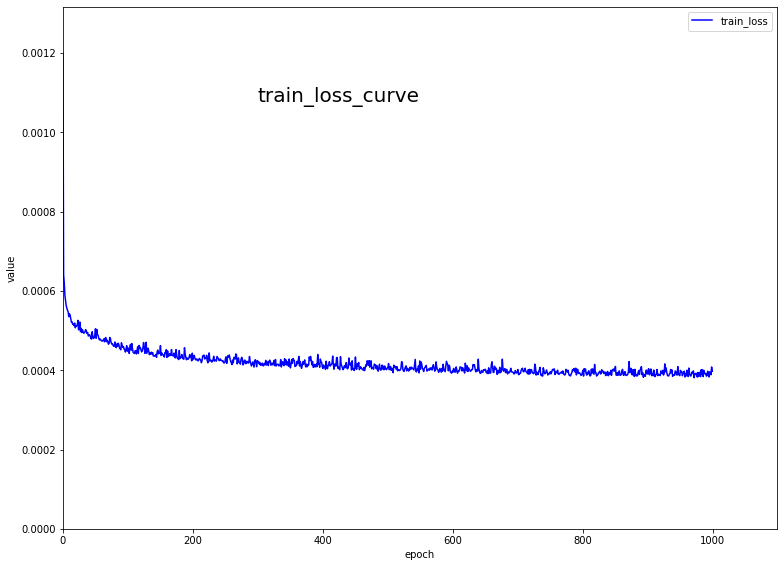

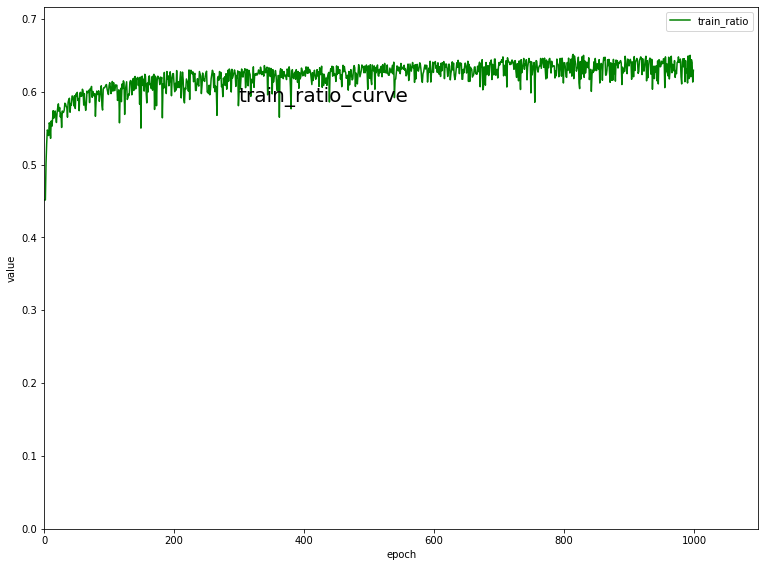

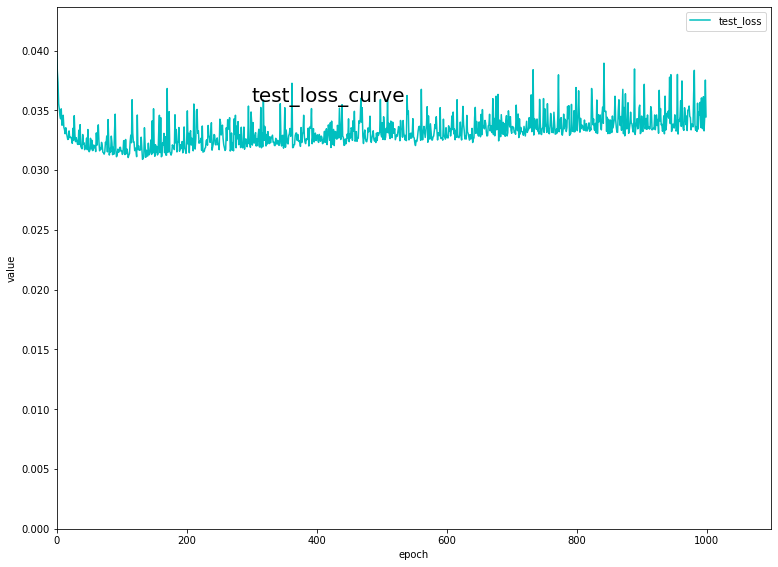

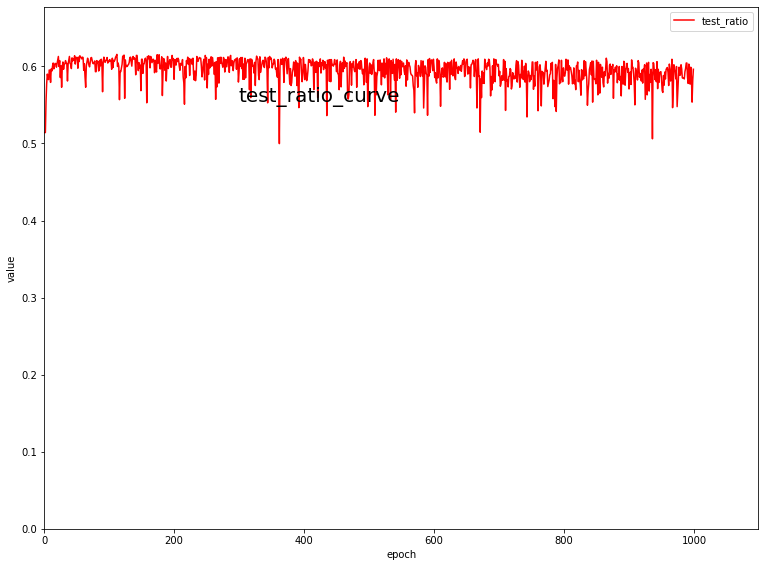

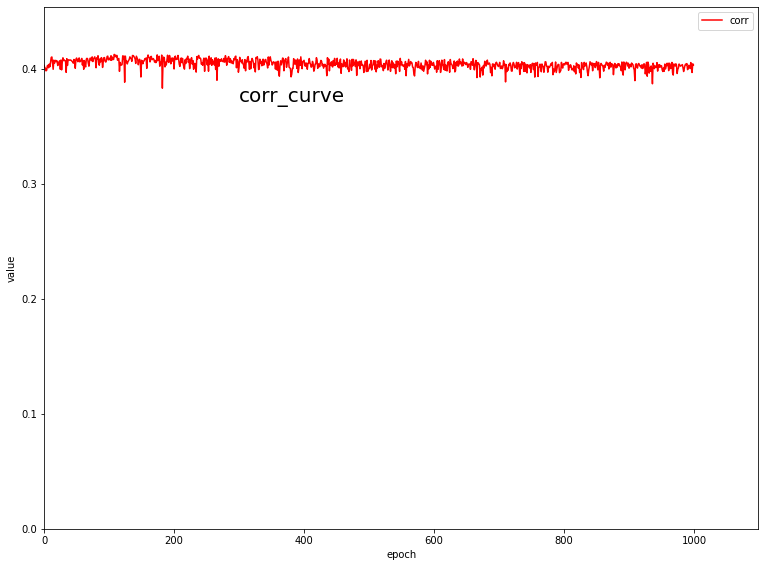

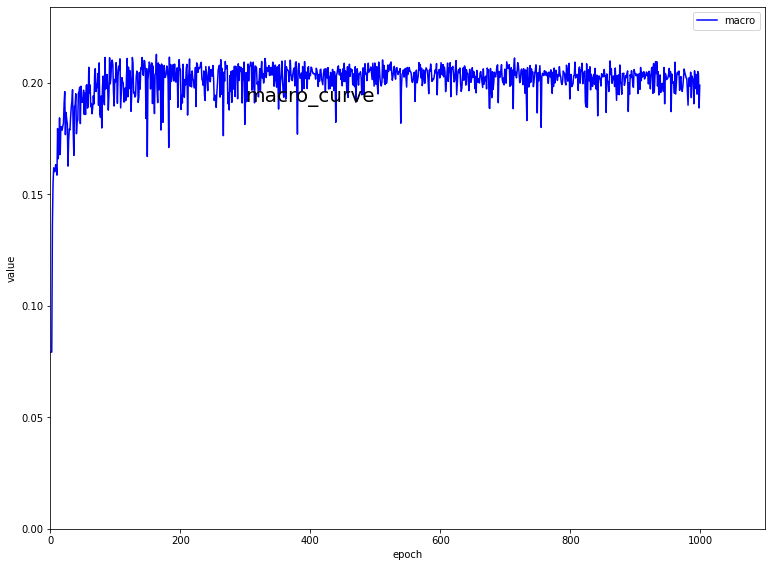

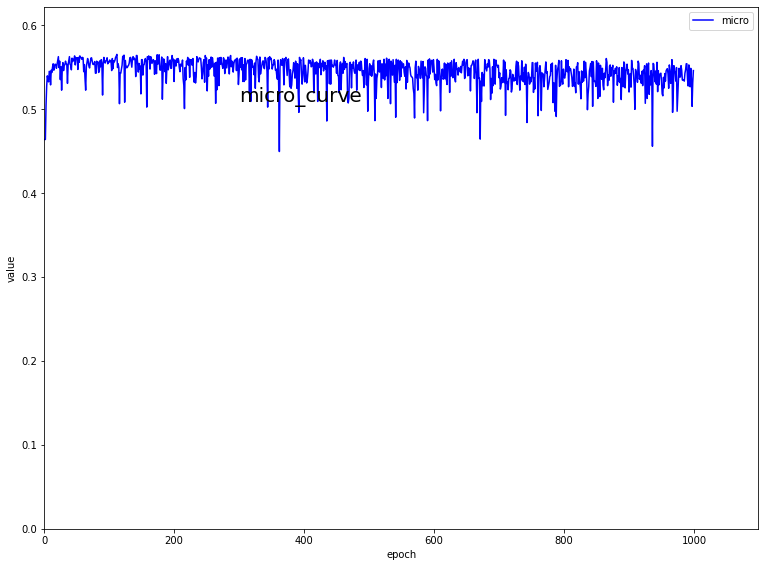

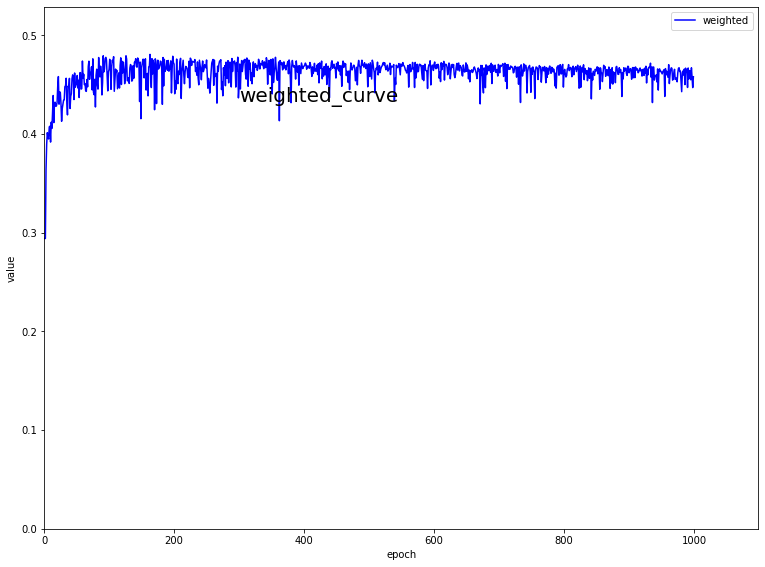

In [72]:
paint('train_loss', 'b')
paint('train_ratio', 'g')
paint('test_loss', 'c')
paint('test_ratio', 'r')
paint('corr', 'r')
paint('macro', 'b')
paint('micro', 'b')
paint('weighted', 'b')

In [44]:
# np.max(test_ratio_list)

# np.argmax(test_ratio_list)

112

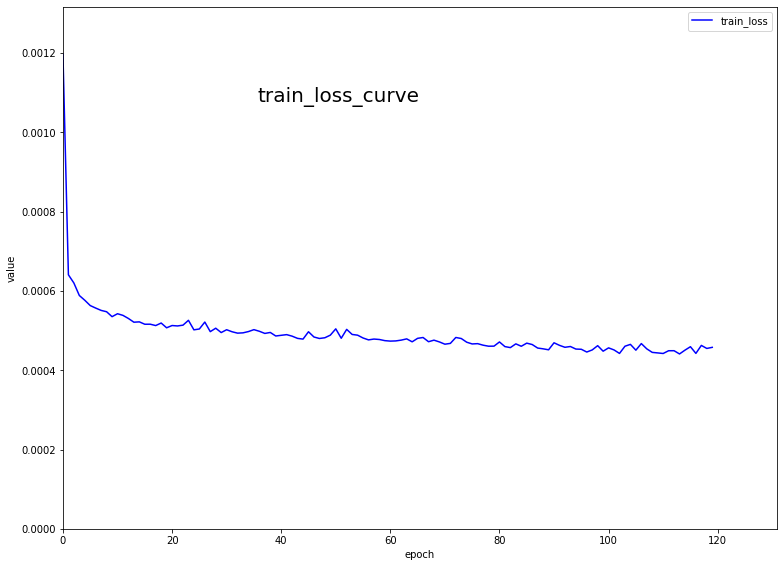

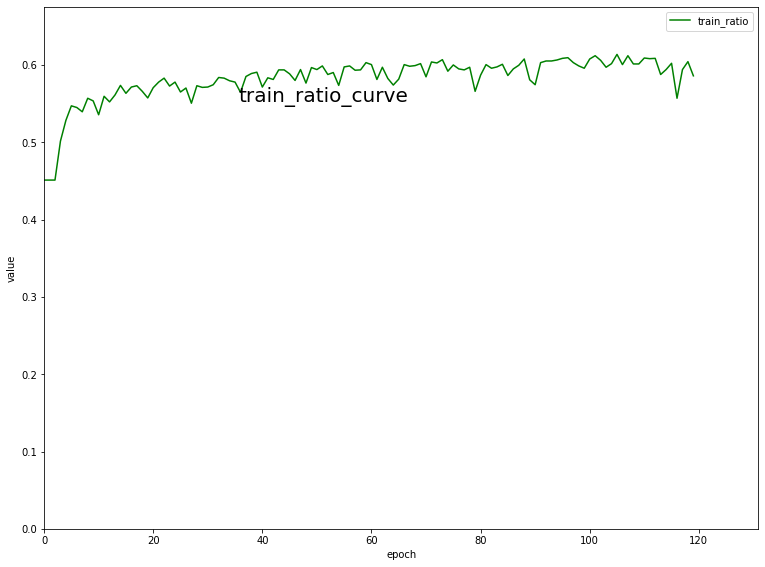

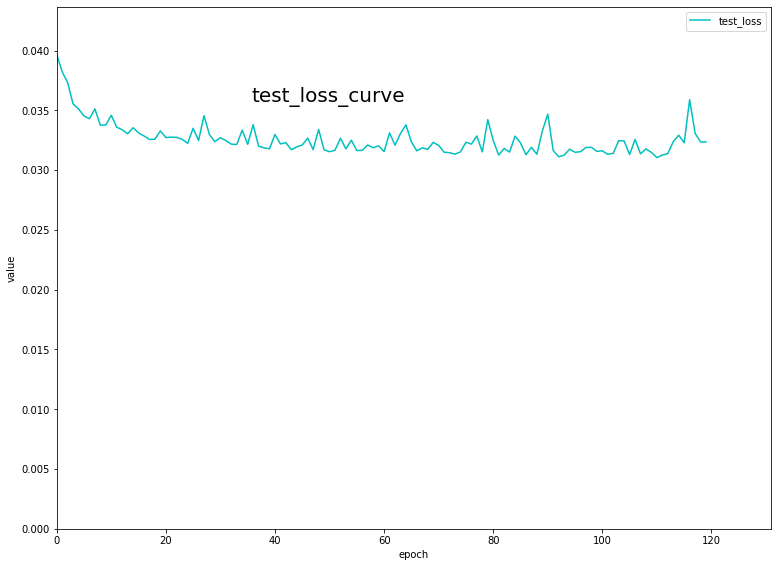

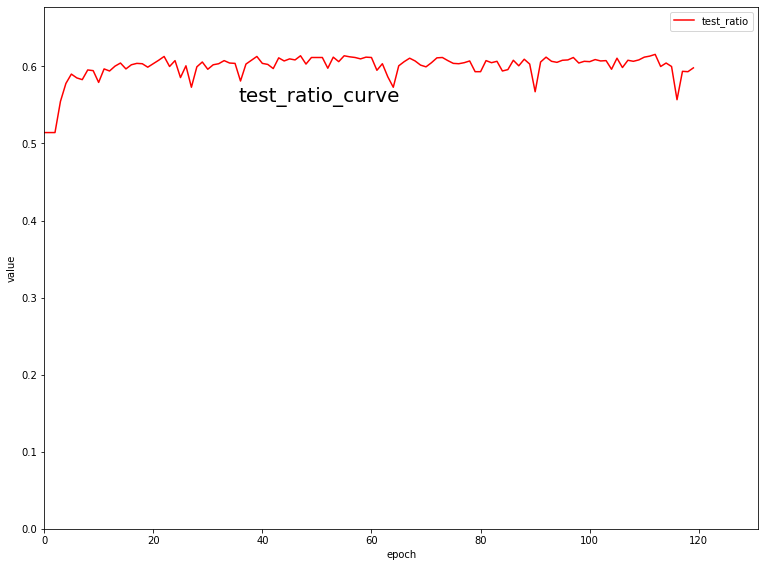

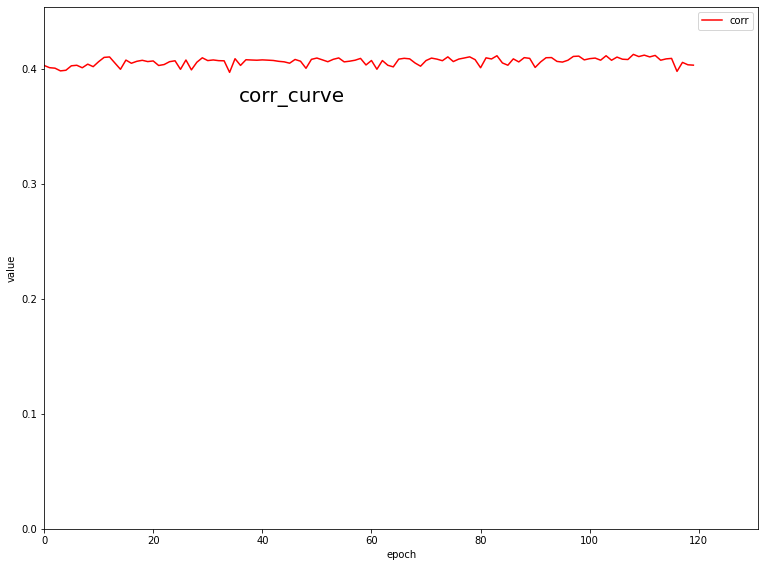

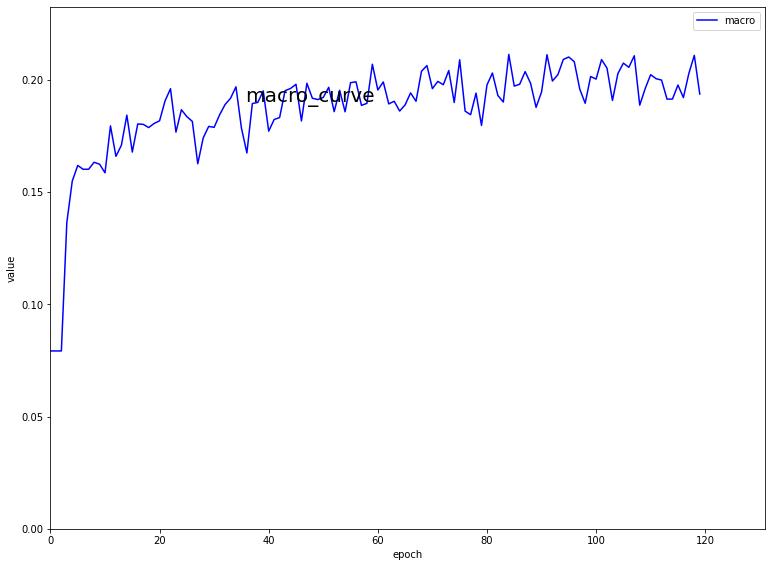

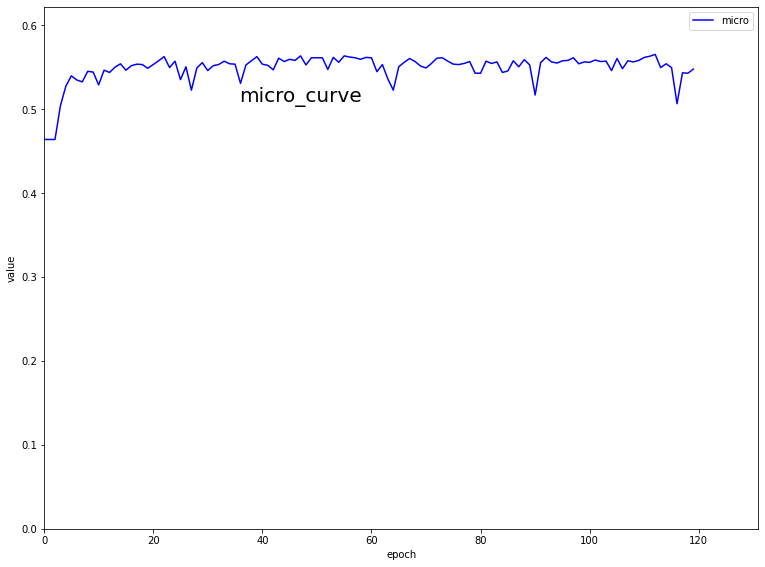

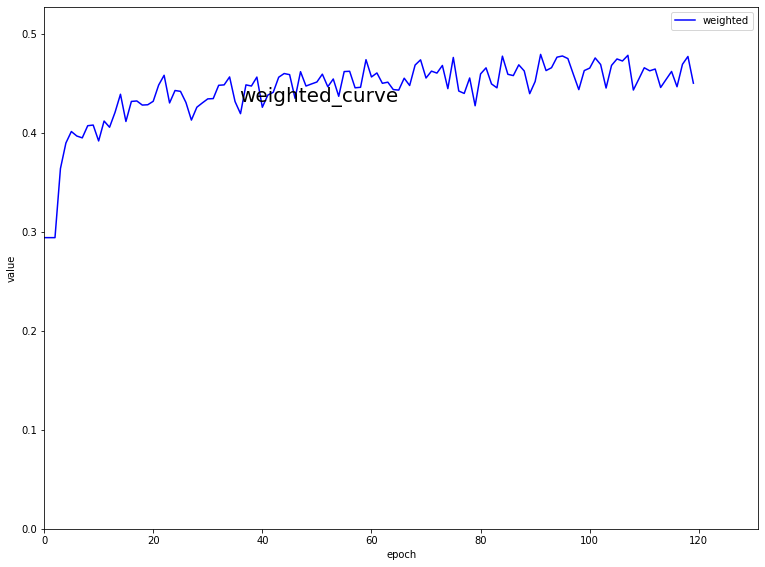

In [73]:
paint('train_loss', 'b', 120)
paint('train_ratio', 'g', 120)
paint('test_loss', 'c', 120)
paint('test_ratio', 'r', 120)
paint('corr', 'r', 120)
paint('macro', 'b', 120)
paint('micro', 'b', 120)
paint('weighted', 'b', 120)

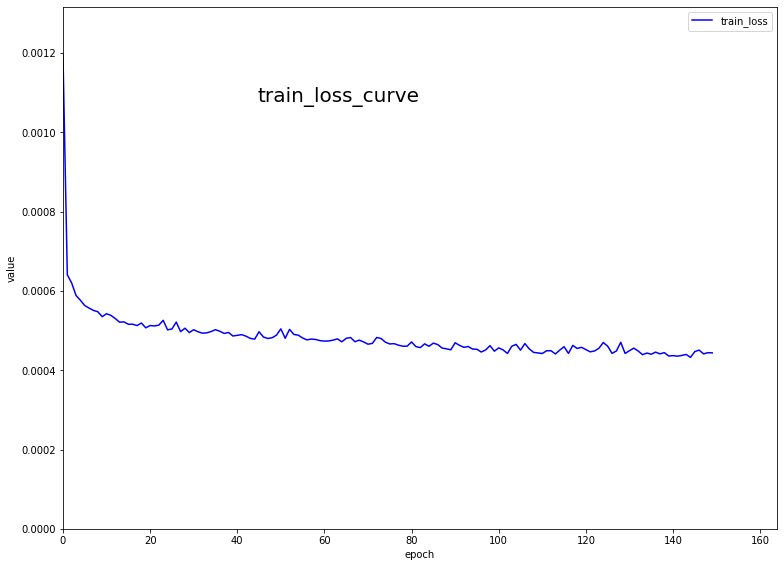

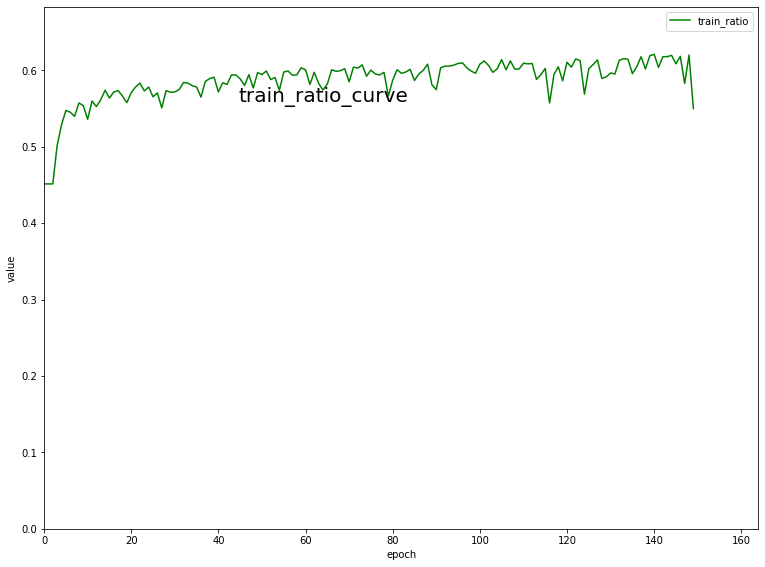

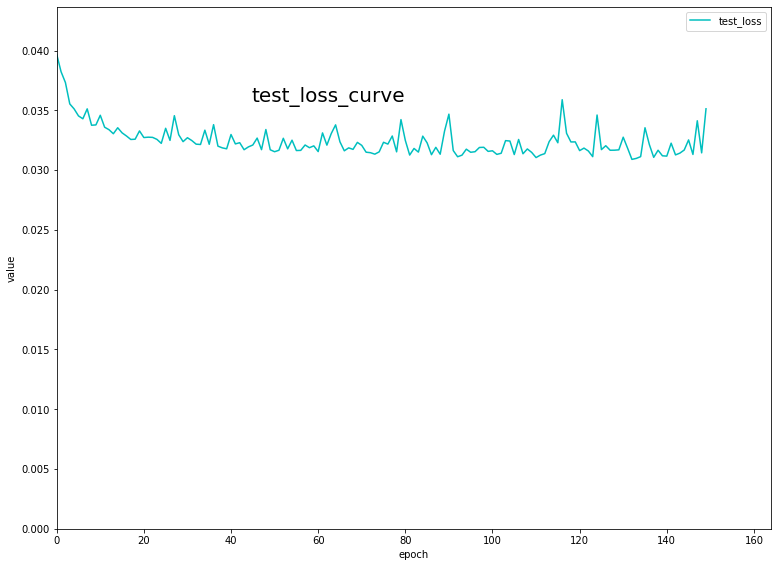

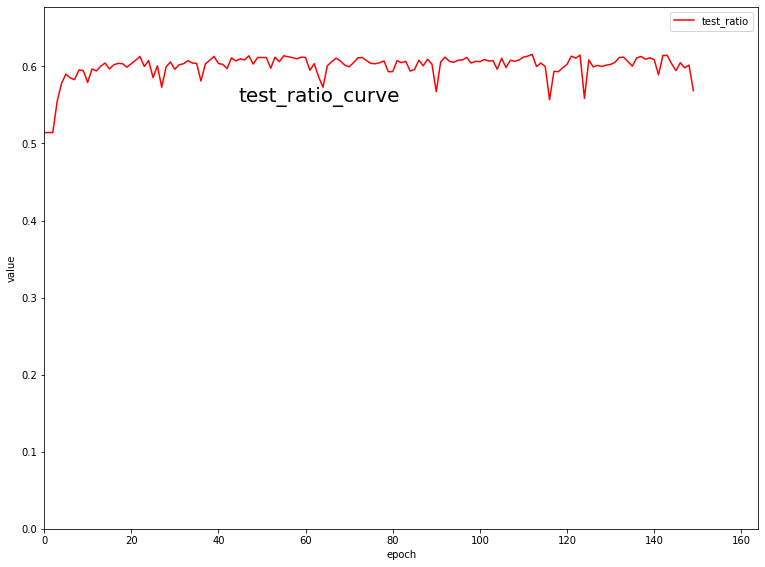

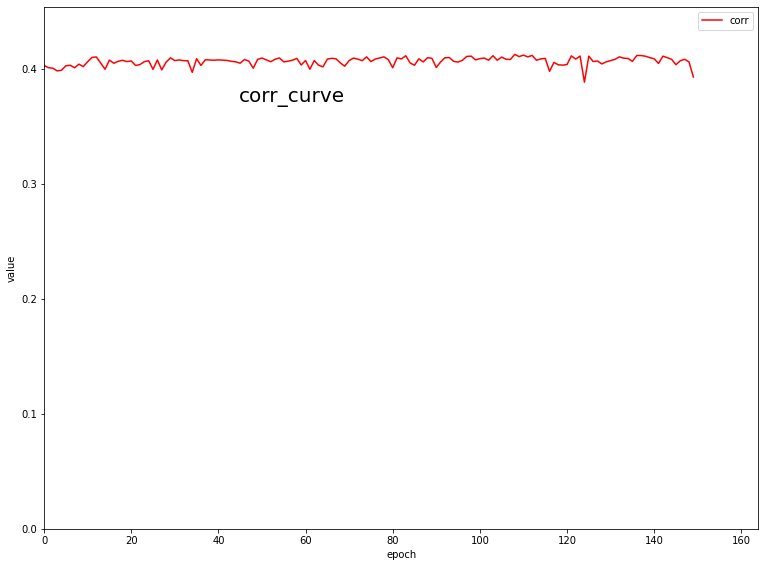

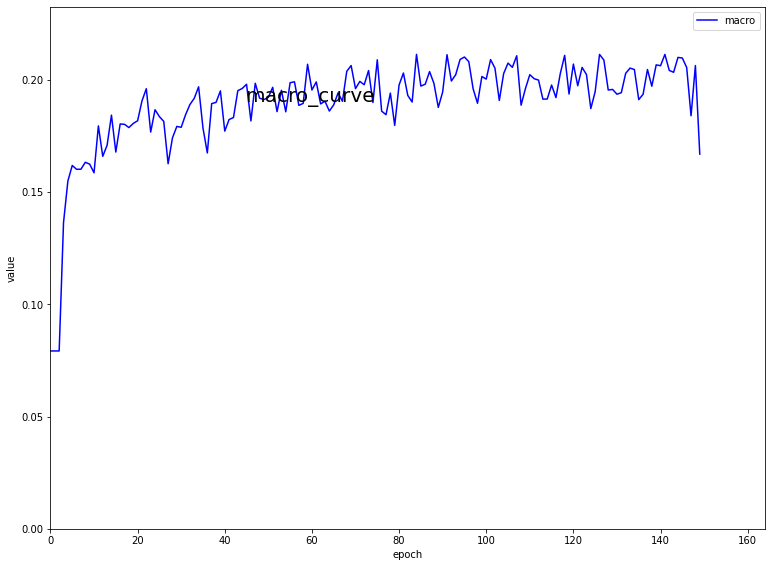

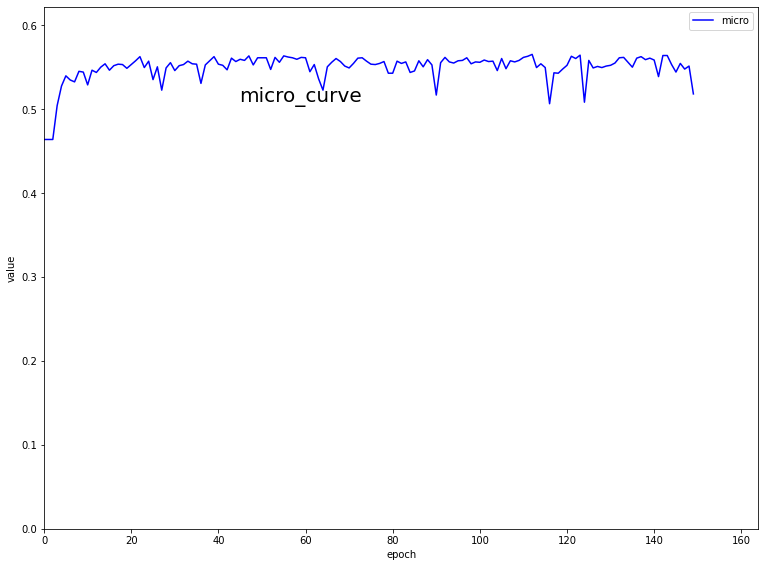

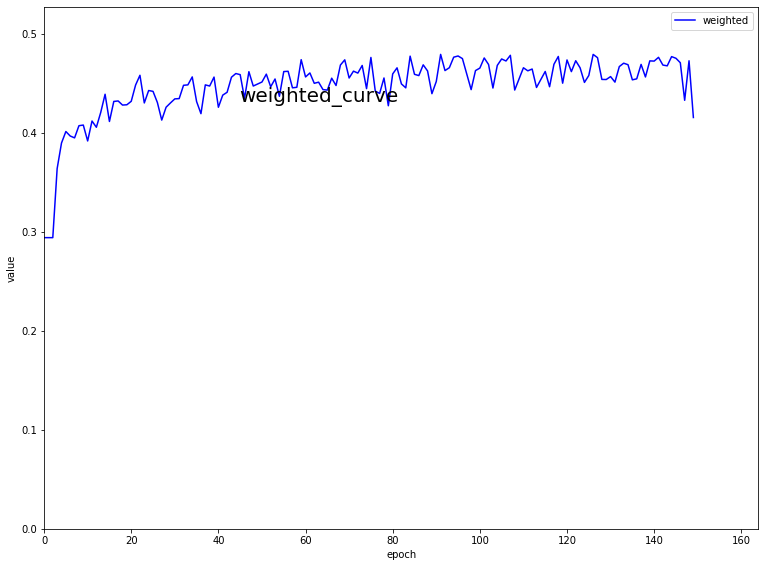

In [74]:
paint('train_loss', 'b', 150)
paint('train_ratio', 'g', 150)
paint('test_loss', 'c', 150)
paint('test_ratio', 'r', 150)
paint('corr', 'r', 150)
paint('macro', 'b', 150)
paint('micro', 'b', 150)
paint('weighted', 'b', 150)

In [14]:
net2 = TwoLayerNet(input_size, hidden_size, output_size)
net2.load_state_dict(torch.load('new_bert_para.dict'))
net2.eval()

cnt = 0
pred_emotions = list()
true_emotions = list()
for feat, label in testset:
    if torch.argmax(net2(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
        cnt += 1
    pred_emotions.append(int(torch.argmax(net2(torch.Tensor(feat))).item()))
    true_emotions.append(int(torch.argmax(torch.Tensor(label)).item()))

print('correct:', cnt)
print('ratio:', cnt / test_size)
# correct: 1274
# ratio: 0.5718132854578097

correct: 1218
ratio: 0.5466786355475763


In [31]:
from scipy.stats import pearsonr

# 返回值的第一项是皮尔森相关系数，第二项是p_value值
pears = list()
for feat, label in testset:
    pred = torch.Tensor(net2(feat)[0]).detach().numpy()
    pears.append(pearsonr(label, pred))

corr = 0
for pair in pears:
    corr += pair[0]
corr /= len(pears)
print('correlation:', corr)

# correlation: 0.6464834652625328

correlation: 0.6257258667917763


In [16]:
from sklearn.metrics import f1_score

print('f1 macro:', f1_score(true_emotions, pred_emotions, average='macro'))
print('f1 micro:', f1_score(true_emotions, pred_emotions, average='weighted'))

# f1 macro: 0.2670135943400833
# f1 micro: 0.5127787501798767

f1 macro: 0.24257136630344678
f1 micro: 0.4988495147861823


In [17]:
# from scipy.stats import pearsonr

# pears = list()
# for feat, label in testset:
#     pred = torch.Tensor(net2(feat)[0]).detach().numpy()
# #     print(pred, label)
#     pears.append(pearsonr(label, pred))

# p1 = 0.0
# p2 = 0.0
# for item in pears:
#     p1 += item[0]
#     p2 += item[1]
# print('p1', p1 / len(pears))
# print('p2', p2 / len(pears))

# with open('pears.json', 'w') as f:
#     json.dump(pears, f)

# 输出：r： 相关系数 [-1，1]之间，p-value: p值。
# p1 0.6341844221534106
# p2 0.18452959612748981

In [18]:
# x_axis = list(range(len(train_loss_list)))

# plt.figure(figsize=(12.8, 9.6))
# plt.xlabel('epoch')
# plt.ylabel('value')
# plt.text(x=20, y=0.45, s='Bert Encoded Accuracy')
# plt.plot(x_axis, train_loss_list, label='train_loss')
# plt.plot(x_axis, test_loss_list, label='test_loss')
# # plt.plot(x_axis, test_ratio_list, label='test_loss')
# plt.legend()
# plt.savefig('bert_ratio_img.png')

# Epoch 0,	 loss 0.051285	ratio: 0.46409335727109513
# Epoch 1,	 loss 0.038453	ratio: 0.5134649910233393
# Epoch 2,	 loss 0.037105	ratio: 0.5296229802513465
# Epoch 3,	 loss 0.034959	ratio: 0.5390484739676841
# Epoch 4,	 loss 0.034951	ratio: 0.553411131059246
# Epoch 5,	 loss 0.034196	ratio: 0.553411131059246
# Epoch 6,	 loss 0.033057	ratio: 0.5556552962298025
# Epoch 7,	 loss 0.032421	ratio: 0.559245960502693
# Epoch 8,	 loss 0.032765	ratio: 0.5067324955116697
# Epoch 9,	 loss 0.032665	ratio: 0.5237881508078994
# Epoch 10,	 loss 0.032997	ratio: 0.5314183123877917
# Epoch 11,	 loss 0.031734	ratio: 0.5291741472172352
# Epoch 12,	 loss 0.033557	ratio: 0.5547576301615799
# Epoch 13,	 loss 0.031748	ratio: 0.5412926391382405
# Epoch 14,	 loss 0.031256	ratio: 0.5623877917414721
# Epoch 15,	 loss 0.030937	ratio: 0.5587971274685817
# Epoch 16,	 loss 0.030552	ratio: 0.5161579892280072
# Epoch 17,	 loss 0.030894	ratio: 0.5659784560143627
# Epoch 18,	 loss 0.031344	ratio: 0.5511669658886894
# Epoch 19,	 loss 0.030259	ratio: 0.5632854578096947
# Epoch 20,	 loss 0.029733	ratio: 0.5619389587073609
# Epoch 21,	 loss 0.028933	ratio: 0.5632854578096947
# Epoch 22,	 loss 0.029858	ratio: 0.5619389587073609
# Epoch 23,	 loss 0.030463	ratio: 0.5412926391382405
# Epoch 24,	 loss 0.029177	ratio: 0.5637342908438061
# Epoch 25,	 loss 0.029449	ratio: 0.5421903052064632
# Epoch 26,	 loss 0.029568	ratio: 0.5085278276481149
# Epoch 27,	 loss 0.030038	ratio: 0.546229802513465
# Epoch 28,	 loss 0.029516	ratio: 0.5691202872531418
# Epoch 29,	 loss 0.028793	ratio: 0.5677737881508079
# Epoch 30,	 loss 0.028567	ratio: 0.5677737881508079
# Epoch 31,	 loss 0.028434	ratio: 0.5803411131059246
# Epoch 32,	 loss 0.027838	ratio: 0.5727109515260324
# Epoch 33,	 loss 0.028084	ratio: 0.5682226211849192
# Epoch 34,	 loss 0.028958	ratio: 0.5677737881508079
# Epoch 35,	 loss 0.028126	ratio: 0.4753141831238779
# Epoch 36,	 loss 0.029443	ratio: 0.5789946140035906
# Epoch 37,	 loss 0.027839	ratio: 0.5758527827648114
# Epoch 38,	 loss 0.027576	ratio: 0.5731597845601436
# Epoch 39,	 loss 0.027412	ratio: 0.5686714542190305
# Epoch 40,	 loss 0.027359	ratio: 0.5650807899461401
# Epoch 41,	 loss 0.027756	ratio: 0.5789946140035906
# Epoch 42,	 loss 0.027371	ratio: 0.5789946140035906
# Epoch 43,	 loss 0.026572	ratio: 0.5789946140035906
# Epoch 44,	 loss 0.028352	ratio: 0.5686714542190305
# Epoch 45,	 loss 0.027282	ratio: 0.5677737881508079
# Epoch 46,	 loss 0.027078	ratio: 0.5641831238779175
# Epoch 47,	 loss 0.027195	ratio: 0.486983842010772
# Epoch 48,	 loss 0.028348	ratio: 0.5578994614003591
# Epoch 49,	 loss 0.027826	ratio: 0.5812387791741472
# Epoch 50,	 loss 0.028830	ratio: 0.5718132854578097
# Epoch 51,	 loss 0.027044	ratio: 0.5727109515260324
# Epoch 52,	 loss 0.026427	ratio: 0.5655296229802513
# Epoch 53,	 loss 0.026585	ratio: 0.5731597845601436
# Epoch 54,	 loss 0.027126	ratio: 0.5632854578096947
# Epoch 55,	 loss 0.028299	ratio: 0.572262118491921
# Epoch 56,	 loss 0.026371	ratio: 0.5704667863554758
# Epoch 57,	 loss 0.026461	ratio: 0.5754039497307002
# Epoch 58,	 loss 0.026668	ratio: 0.579443447037702
# Epoch 59,	 loss 0.026746	ratio: 0.5614901256732495
# Epoch 60,	 loss 0.026423	ratio: 0.5727109515260324
# Epoch 61,	 loss 0.027045	ratio: 0.5655296229802513
# Epoch 62,	 loss 0.026864	ratio: 0.559245960502693
# Epoch 63,	 loss 0.026186	ratio: 0.5718132854578097
# Epoch 64,	 loss 0.027070	ratio: 0.5192998204667864
# Epoch 65,	 loss 0.028984	ratio: 0.5740574506283662
# Epoch 66,	 loss 0.026851	ratio: 0.5740574506283662
# Epoch 67,	 loss 0.026064	ratio: 0.5700179533213644
# Epoch 68,	 loss 0.026883	ratio: 0.5493716337522442
# Epoch 69,	 loss 0.027471	ratio: 0.5709156193895871
# Epoch 70,	 loss 0.025595	ratio: 0.5713644524236984
# Epoch 71,	 loss 0.025773	ratio: 0.579443447037702
# Epoch 72,	 loss 0.025657	ratio: 0.5700179533213644
# Epoch 73,	 loss 0.025794	ratio: 0.5821364452423698
# Epoch 74,	 loss 0.026337	ratio: 0.5763016157989228
# Epoch 75,	 loss 0.025759	ratio: 0.5713644524236984
# Epoch 76,	 loss 0.025794	ratio: 0.5695691202872532
# Epoch 77,	 loss 0.025472	ratio: 0.5614901256732495
# Epoch 78,	 loss 0.025500	ratio: 0.5718132854578097
# Epoch 79,	 loss 0.025555	ratio: 0.5767504488330341
# Epoch 80,	 loss 0.025623	ratio: 0.5758527827648114
# Epoch 81,	 loss 0.026223	ratio: 0.5578994614003591
# Epoch 82,	 loss 0.025172	ratio: 0.578096947935368
# Epoch 83,	 loss 0.025576	ratio: 0.5502692998204668
# Epoch 84,	 loss 0.025582	ratio: 0.5727109515260324
# Epoch 85,	 loss 0.024769	ratio: 0.5740574506283662
# Epoch 86,	 loss 0.025430	ratio: 0.5709156193895871
# Epoch 87,	 loss 0.025540	ratio: 0.5686714542190305
# Epoch 88,	 loss 0.025727	ratio: 0.5704667863554758
# Epoch 89,	 loss 0.025313	ratio: 0.547576301615799
# Epoch 90,	 loss 0.025591	ratio: 0.5628366247755835
# Epoch 91,	 loss 0.025231	ratio: 0.5758527827648114
# Epoch 92,	 loss 0.026545	ratio: 0.5570017953321365
# Epoch 93,	 loss 0.025281	ratio: 0.5803411131059246
# Epoch 94,	 loss 0.025095	ratio: 0.5614901256732495
# Epoch 95,	 loss 0.025842	ratio: 0.5637342908438061
# Epoch 96,	 loss 0.025332	ratio: 0.5713644524236984
# Epoch 97,	 loss 0.026553	ratio: 0.5695691202872532
# Epoch 98,	 loss 0.025913	ratio: 0.5749551166965888
# Epoch 99,	 loss 0.024912	ratio: 0.5718132854578097




# Epoch 0,	 loss 0.045432	ratio: 0.46409335727109513
# Epoch 1,	 loss 0.039373	ratio: 0.4995511669658887
# Epoch 2,	 loss 0.037678	ratio: 0.466786355475763
# Epoch 3,	 loss 0.036201	ratio: 0.5089766606822262
# Epoch 4,	 loss 0.034958	ratio: 0.5323159784560144
# Epoch 5,	 loss 0.034222	ratio: 0.5228904847396768
# Epoch 6,	 loss 0.034010	ratio: 0.5224416517055656
# Epoch 7,	 loss 0.033709	ratio: 0.5372531418312387
# Epoch 8,	 loss 0.032776	ratio: 0.5561041292639138
# Epoch 9,	 loss 0.032886	ratio: 0.5502692998204668
# Epoch 10,	 loss 0.032159	ratio: 0.5516157989228008
# Epoch 11,	 loss 0.031773	ratio: 0.5605924596050269
# Epoch 12,	 loss 0.031317	ratio: 0.5552064631956912
# Epoch 13,	 loss 0.031317	ratio: 0.559245960502693
# Epoch 14,	 loss 0.031216	ratio: 0.5561041292639138
# Epoch 15,	 loss 0.031044	ratio: 0.5547576301615799
# Epoch 16,	 loss 0.031177	ratio: 0.5574506283662477
# Epoch 17,	 loss 0.030785	ratio: 0.5596947935368043
# Epoch 18,	 loss 0.030777	ratio: 0.5570017953321365
# Epoch 19,	 loss 0.030816	ratio: 0.5610412926391383
# Epoch 20,	 loss 0.030038	ratio: 0.5578994614003591
# Epoch 21,	 loss 0.029829	ratio: 0.5700179533213644
# Epoch 22,	 loss 0.029730	ratio: 0.5632854578096947
# Epoch 23,	 loss 0.029558	ratio: 0.5691202872531418
# Epoch 24,	 loss 0.029560	ratio: 0.5677737881508079
# Epoch 25,	 loss 0.030217	ratio: 0.5628366247755835
# Epoch 26,	 loss 0.029276	ratio: 0.5659784560143627
# Epoch 27,	 loss 0.029422	ratio: 0.5677737881508079
# Epoch 28,	 loss 0.028932	ratio: 0.5776481149012568
# Epoch 29,	 loss 0.028831	ratio: 0.5686714542190305
# Epoch 30,	 loss 0.028355	ratio: 0.5641831238779175
# Epoch 31,	 loss 0.028586	ratio: 0.5686714542190305
# Epoch 32,	 loss 0.028435	ratio: 0.5807899461400359
# Epoch 33,	 loss 0.028330	ratio: 0.5516157989228008
# Epoch 34,	 loss 0.028642	ratio: 0.5659784560143627
# Epoch 35,	 loss 0.028451	ratio: 0.5740574506283662
# Epoch 36,	 loss 0.027836	ratio: 0.5641831238779175
# Epoch 37,	 loss 0.027991	ratio: 0.5776481149012568
# Epoch 38,	 loss 0.027590	ratio: 0.5695691202872532
# Epoch 39,	 loss 0.027974	ratio: 0.5628366247755835
# Epoch 40,	 loss 0.027954	ratio: 0.5686714542190305
# Epoch 41,	 loss 0.027947	ratio: 0.5619389587073609
# Epoch 42,	 loss 0.027999	ratio: 0.5601436265709157
# Epoch 43,	 loss 0.027518	ratio: 0.5718132854578097
# Epoch 44,	 loss 0.027476	ratio: 0.5543087971274686
# Epoch 45,	 loss 0.028381	ratio: 0.5547576301615799
# Epoch 46,	 loss 0.027920	ratio: 0.5713644524236984
# Epoch 47,	 loss 0.027171	ratio: 0.5763016157989228
# Epoch 48,	 loss 0.027071	ratio: 0.572262118491921
# Epoch 49,	 loss 0.027245	ratio: 0.5713644524236984
# Epoch 50,	 loss 0.026848	ratio: 0.5731597845601436
# Epoch 51,	 loss 0.027465	ratio: 0.5807899461400359
# Epoch 52,	 loss 0.026775	ratio: 0.5830341113105925
# Epoch 53,	 loss 0.027467	ratio: 0.5727109515260324
# Epoch 54,	 loss 0.026910	ratio: 0.5754039497307002
# Epoch 55,	 loss 0.026469	ratio: 0.5843806104129264
# Epoch 56,	 loss 0.026890	ratio: 0.5668761220825853
# Epoch 57,	 loss 0.026615	ratio: 0.5807899461400359
# Epoch 58,	 loss 0.026565	ratio: 0.5686714542190305
# Epoch 59,	 loss 0.026535	ratio: 0.572262118491921
# Epoch 60,	 loss 0.026011	ratio: 0.5798922800718133
# Epoch 61,	 loss 0.027057	ratio: 0.5570017953321365
# Epoch 62,	 loss 0.026805	ratio: 0.5816876122082585
# Epoch 63,	 loss 0.026516	ratio: 0.578096947935368
# Epoch 64,	 loss 0.026416	ratio: 0.573608617594255
# Epoch 65,	 loss 0.026567	ratio: 0.566427289048474
# Epoch 66,	 loss 0.026507	ratio: 0.5749551166965888
# Epoch 67,	 loss 0.026313	ratio: 0.5843806104129264
# Epoch 68,	 loss 0.026006	ratio: 0.585278276481149
# Epoch 69,	 loss 0.025633	ratio: 0.5650807899461401
# Epoch 70,	 loss 0.025654	ratio: 0.5745062836624776
# Epoch 71,	 loss 0.026604	ratio: 0.547576301615799
# Epoch 72,	 loss 0.026075	ratio: 0.578096947935368
# Epoch 73,	 loss 0.025772	ratio: 0.5839317773788151
# Epoch 74,	 loss 0.025592	ratio: 0.5839317773788151
# Epoch 75,	 loss 0.025724	ratio: 0.5803411131059246
# Epoch 76,	 loss 0.025317	ratio: 0.5552064631956912
# Epoch 77,	 loss 0.025449	ratio: 0.5843806104129264
# Epoch 78,	 loss 0.025436	ratio: 0.5834829443447038
# Epoch 79,	 loss 0.025329	ratio: 0.5619389587073609
# Epoch 80,	 loss 0.025453	ratio: 0.5879712746858169
# Epoch 81,	 loss 0.025197	ratio: 0.585278276481149
# Epoch 82,	 loss 0.024840	ratio: 0.5812387791741472
# Epoch 83,	 loss 0.024716	ratio: 0.5848294434470377
# Epoch 84,	 loss 0.025154	ratio: 0.5821364452423698
# Epoch 85,	 loss 0.025126	ratio: 0.5848294434470377
# Epoch 86,	 loss 0.025548	ratio: 0.5857271095152603
# Epoch 87,	 loss 0.025207	ratio: 0.5798922800718133
# Epoch 88,	 loss 0.024857	ratio: 0.5798922800718133
# Epoch 89,	 loss 0.024444	ratio: 0.5803411131059246
# Epoch 90,	 loss 0.024373	ratio: 0.5763016157989228
# Epoch 91,	 loss 0.024561	ratio: 0.5839317773788151
# Epoch 92,	 loss 0.024584	ratio: 0.5776481149012568
# Epoch 93,	 loss 0.024601	ratio: 0.5879712746858169
# Epoch 94,	 loss 0.024815	ratio: 0.572262118491921
# Epoch 95,	 loss 0.024604	ratio: 0.5561041292639138
# Epoch 96,	 loss 0.024902	ratio: 0.5857271095152603
# Epoch 97,	 loss 0.024123	ratio: 0.5709156193895871
# Epoch 98,	 loss 0.024384	ratio: 0.572262118491921
# Epoch 99,	 loss 0.024700	ratio: 0.5655296229802513